In [1]:
%%capture
!pip install unsloth
# Also get the latest nightly Unsloth!
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

# Install Flash Attention 2 for softcapping support
import torch
if torch.cuda.get_device_capability()[0] >= 8:
    !pip install --no-deps packaging ninja einops "flash-attn>=2.6.3"

In [3]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Meta-Llama-3.1-8B-bnb-4bit",      # Llama-3.1 15 trillion tokens model 2x faster!
    "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    "unsloth/Meta-Llama-3.1-70B-bnb-4bit",
    "unsloth/Meta-Llama-3.1-405B-bnb-4bit",    # We also uploaded 4bit for 405b!
    "unsloth/Mistral-Nemo-Base-2407-bnb-4bit", # New Mistral 12b 2x faster!
    "unsloth/Mistral-Nemo-Instruct-2407-bnb-4bit",
    "unsloth/mistral-7b-v0.3-bnb-4bit",        # Mistral v3 2x faster!
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/Phi-3.5-mini-instruct",           # Phi-3.5 2x faster!
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/gemma-2-9b-bnb-4bit",
    "unsloth/gemma-2-27b-bnb-4bit",            # Gemma 2x faster!
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/gemma-2-9b-it",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

==((====))==  Unsloth 2024.9.post4: Fast Gemma2 patching. Transformers = 4.44.2.
   \\   /|    GPU: NVIDIA A100-SXM4-40GB. Max memory: 39.381 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.4.1+cu121. CUDA = 8.0. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post1. FA2 = True]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

In [4]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 256, 
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 256,
    lora_dropout = 0, 
    bias = "none",   
    use_gradient_checkpointing = "unsloth", 
    random_state = 3407,
    use_rslora = False,  
    loftq_config = None, 
)

Unsloth 2024.9.post4 patched 42 layers with 42 QKV layers, 42 O layers and 42 MLP layers.


In [13]:
LANGUAGE_MAP = {
    "en": "english", "zh": "chinese", "es": "spanish", "fr": "french",
    "tr": "turkish", "ar": "arabic", "ru": "russian", "it": "italian"
}

In [5]:
from datasets import load_dataset
dataset = load_dataset("facebook/xnli","all_languages",split = "train")



README.md:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

train-00000-of-00004.parquet:   0%|          | 0.00/238M [00:00<?, ?B/s]

train-00001-of-00004.parquet:   0%|          | 0.00/239M [00:00<?, ?B/s]

train-00002-of-00004.parquet:   0%|          | 0.00/238M [00:00<?, ?B/s]

train-00003-of-00004.parquet:   0%|          | 0.00/239M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/6.77M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/3.39M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5010 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2490 [00:00<?, ? examples/s]

In [9]:
df=dataset.to_pandas()

premise  \
0       {'ar': '- و قد ال كريم المفاهيمية اثنان اساسيي...   
1       {'ar': 'انت تعرف خلال الموسم و اعتقد انه عند ا...   
2       {'ar': 'واحدة من رقابنا ستقوم بتنفيذ تعليماتك ...   
3       {'ar': 'وكيف تعرف ذلك ? كل هذا هو معلوماتهم مر...   
4       {'ar': 'نعم , انا اقول لك ماذا لو ذهبت ل السعر...   
...                                                   ...   
392697  {'ar': 'ومن الواضح ان كاليفورنيا يمكنها - ويجب...   
392698  {'ar': 'وقد كان ينظر اليه مرة على انه اجمل شار...   
392699  {'ar': 'قوراب قوراب هي تقليد محفوظ بشكل جميل ف...   
392700  {'ar': 'ذكرت الوفيات بشكل مولع مناقشاته على ال...   
392701  {'ar': 'في ذلك الاخر انت تعرف انني يجب ان افعل...   

                                               hypothesis  label  
0       {'language': ['ar', 'bg', 'de', 'el', 'en', 'e...      1  
1       {'language': ['ar', 'bg', 'de', 'el', 'en', 'e...      0  
2       {'language': ['ar', 'bg', 'de', 'el', 'en', 'e...      0  
3       {'language': ['ar', 'bg', 'de', 'el', 'en', 'e...      0  
4       {'language': ['ar', 'bg', 'de', 'el', 'en', 'e...      1  
...                                                   ...    ...  
392697  {'language': ['ar', 'bg', 'de', 'el', 'en', 'e...      2  
392698  {'language': ['ar', 'bg', 'de', 'el', 'en', 'e...      1  
392699  {'language': ['ar', 'bg', 'de', 'el', 'en', 'e...      0  
392700  {'language': ['ar', 'bg', 'de', 'el', 'en', 'e...      1  
392701  {'language': ['ar', 'bg', 'de', 'el', 'en', 'e...      1  

[392702 rows x 3 columns]

In [11]:
q=df['premise'].iloc[0]

In [52]:
def translate_dict(translations, pairs):
    result = []
    for source, target in pairs:
        if source in translations and target in translations:
            result.append([[source, target],{
                'source': translations[source],
                'target': translations[target]
            }])
    return result

In [53]:
system_prompt = """
Translate the given text from {} language to {} language. While translating, please adhere to the following rules:

1. Return the output in JSON format.
2. Do not add anything extra to the output.
3. Do not deviate from the content of the input text.
4. Do not translate the JSON keys "product_name" and "product_detailed_description".
5. When translating, make exact matching translations. Be careful
6. Translating proper names and brand names.
7. Translate carefully. 

"""

In [63]:
from itertools import combinations
import numpy as np
def common_keys_values(dict1, dict2):
    common_keys = set(dict1.keys()) & set(dict2.keys())
    keys=[key for key in common_keys]
    comb=list(combinations(keys, 2))
    
    return np.array(translate_dict(dict1,comb))

In [72]:
def translate_dict(translations, pairs):
    result = []
    for source, target in pairs:
        if source in translations and target in translations:
            result.append([[source, target], {
                'source': translations[source],
                'target': translations[target]
            }])
    return result

def common_keys_values(dict1, dict2):
    common_keys = set(dict1.keys()) & set(dict2.keys())
    keys = list(common_keys)
    comb = list(combinations(keys, 2))
    
    results = translate_dict(dict1, comb)

    # Find the maximum length of the results
    max_length = max(len(result) for result in results) if results else 0
    
    # Pad results to make them homogeneous
    padded_results = [result + [None] * (max_length - len(result)) for result in results]

    return np.array(padded_results, dtype=object)

In [73]:
k=common_keys_values(q,LANGUAGE_MAP)

array([[list(['es', 'tr']),
        {'source': 'Los robando de crema conceptualmente tienen dos dimensiones básicas : producto y geografía .', 'target': 'Kavramsal krem kaymağını iki temel boyutu vardır - ürün ve coğrafya .'}],
       [list(['es', 'ar']),
        {'source': 'Los robando de crema conceptualmente tienen dos dimensiones básicas : producto y geografía .', 'target': '- و قد ال كريم المفاهيمية اثنان اساسيين - المنتج والجغرافيا .'}],
       [list(['es', 'ru']),
        {'source': 'Los robando de crema conceptualmente tienen dos dimensiones básicas : producto y geografía .', 'target': 'Концептуально крем крем имеет два основных измерения - продукт и география .'}],
       [list(['es', 'zh']),
        {'source': 'Los robando de crema conceptualmente tienen dos dimensiones básicas : producto y geografía .', 'target': '从 概念 上 看 , 奶油 收入 有 两 个 基本 方面 产品 和 地理 .'}],
       [list(['es', 'en']),
        {'source': 'Los robando de crema conceptualmente tienen dos dimensiones básicas : pr

In [79]:
data=[]

for i in k:
        {
      "product_name": i[1]['source'],
      "product_detailed_description": ""
        }
    s=system_prompt.format(LANGUAGE_MAP[i[0][0]],LANGUAGE_MAP[i[0][1]])
    
    print(s)
    break


Translate the given text from spanish language to turkish language. While translating, please adhere to the following rules:

1. Return the output in JSON format.
2. Do not add anything extra to the output.
3. Do not deviate from the content of the input text.
4. Do not translate the JSON keys "product_name" and "product_detailed_description".
5. When translating, make exact matching translations. Be careful
6. Translating proper names and brand names.
7. Translate carefully. 




In [ ]:


EOS_TOKEN = tokenizer.eos_token
def formatting_prompts_func(examples):
    instructions = examples["instruction"]
    inputs       = examples["input"]
    outputs      = examples["output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = alpaca_prompt.format(instruction, input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }
pass

from datasets import load_dataset
dataset = load_dataset("yahma/alpaca-cleaned", split = "train")
dataset = dataset.map(formatting_prompts_func, batched = True,)

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),
)

In [ ]:
trainer_stats = trainer.train()

In [ ]:
# alpaca_prompt = Copied from above
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    alpaca_prompt.format(
        "Continue the fibonnaci sequence.", # instruction
        "1, 1, 2, 3, 5, 8", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128)

In [ ]:
model.save_pretrained_gguf("model", tokenizer, quantization_method = "q4_k_m")

In [85]:
prompt="""
{
  "8": {
    "inputs": {
      "samples": [
        "121",
        0
      ],
      "vae": [
        "10",
        0
      ]
    },
    "class_type": "VAEDecode",
    "_meta": {
      "title": "VAE Decode"
    }
  },
  "10": {
    "inputs": {
      "vae_name": "ae.safetensors"
    },
    "class_type": "VAELoader",
    "_meta": {
      "title": "Load VAE"
    }
  },
  "16": {
    "inputs": {
      "sampler_name": "euler"
    },
    "class_type": "KSamplerSelect",
    "_meta": {
      "title": "KSamplerSelect"
    }
  },
  "17": {
    "inputs": {
      "scheduler": "beta",
      "steps": 8,
      "denoise": 1,
      "model": [
        "62",
        0
      ]
    },
    "class_type": "BasicScheduler",
    "_meta": {
      "title": "BasicScheduler"
    }
  },
  "22": {
    "inputs": {
      "model": [
        "118",
        0
      ],
      "conditioning": [
        "72",
        0
      ]
    },
    "class_type": "BasicGuider",
    "_meta": {
      "title": "BasicGuider"
    }
  },
  "25": {
    "inputs": {
      "noise_seed": 42
    },
    "class_type": "RandomNoise",
    "_meta": {
      "title": "RandomNoise"
    }
  },
  "31": {
    "inputs": {
      "text": [
        "89",
        0
      ],
      "clip": [
        "124",
        0
      ]
    },
    "class_type": "CLIPTextEncode",
    "_meta": {
      "title": "CLIP Text Encode (Prompt)"
    }
  },
  "62": {
    "inputs": {
      "max_shift": 2.06,
      "base_shift": 0.5,
      "width": 1024,
      "height": 1280,
      "model": [
        "118",
        0
      ]
    },
    "class_type": "ModelSamplingFlux",
    "_meta": {
      "title": "ModelSamplingFlux"
    }
  },
  "63": {
    "inputs": {
      "image": "canvas (1).png",
      "upload": "image"
    },
    "class_type": "LoadImage",
    "_meta": {
      "title": "Load Image"
    }
  },
  "69": {
    "inputs": {
      "images": [
        "71",
        0
      ]
    },
    "class_type": "PreviewImage",
    "_meta": {
      "title": "Preview Image"
    }
  },
  "71": {
    "inputs": {
      "width": 1024,
      "height": 1280,
      "upscale_method": "lanczos",
      "keep_proportion": true,
      "divisible_by": 2,
      "crop": "disabled",
      "image": [
        "63",
        0
      ]
    },
    "class_type": "ImageResizeKJ",
    "_meta": {
      "title": "Resize Image"
    }
  },
  "72": {
    "inputs": {
      "guidance": 3,
      "conditioning": [
        "106",
        0
      ]
    },
    "class_type": "FluxGuidance",
    "_meta": {
      "title": "FluxGuidance"
    }
  },
  "73": {
    "inputs": {
      "rgthree_comparer": {
        "images": [
          {
            "name": "A",
            "selected": true,
            "url": "/api/view?filename=rgthree.compare._temp_noecm_00001_.png&type=temp&subfolder=&rand=0.1874873156029615"
          },
          {
            "name": "B",
            "selected": true,
            "url": "/api/view?filename=rgthree.compare._temp_noecm_00002_.png&type=temp&subfolder=&rand=0.3791072522819894"
          }
        ]
      },
      "image_a": [
        "8",
        0
      ],
      "image_b": [
        "71",
        0
      ]
    },
    "class_type": "Image Comparer (rgthree)",
    "_meta": {
      "title": "Image Comparer (rgthree)"
    }
  },
  "82": {
    "inputs": {
      "width": 1024,
      "height": 1280,
      "batch_size": 1
    },
    "class_type": "EmptyLatentImage",
    "_meta": {
      "title": "Empty Latent Image"
    }
  },
  "89": {
    "inputs": {
      "text": "product rendering, centered"
    },
    "class_type": "Text Multiline",
    "_meta": {
      "title": "PROMPT"
    }
  },
  "104": {
    "inputs": {
      "type": "auto",
      "control_net": [
        "117",
        0
      ]
    },
    "class_type": "SetUnionControlNetType",
    "_meta": {
      "title": "SetUnionControlNetType"
    }
  },
  "106": {
    "inputs": {
      "strength": 0.55,
      "start_percent": 0,
      "end_percent": 0.45,
      "positive": [
        "31",
        0
      ],
      "negative": [
        "112",
        0
      ],
      "control_net": [
        "104",
        0
      ],
      "image": [
        "71",
        0
      ],
      "vae": [
        "10",
        0
      ]
    },
    "class_type": "ControlNetApplyAdvanced",
    "_meta": {
      "title": "Apply ControlNet"
    }
  },
  "109": {
    "inputs": {
      "preprocessor": "CannyEdgePreprocessor",
      "resolution": 768,
      "image": [
        "71",
        0
      ]
    },
    "class_type": "AIO_Preprocessor",
    "_meta": {
      "title": "AIO Aux Preprocessor"
    }
  },
  "110": {
    "inputs": {
      "images": [
        "109",
        0
      ]
    },
    "class_type": "PreviewImage",
    "_meta": {
      "title": "Preview Image"
    }
  },
  "112": {
    "inputs": {
      "text": "nothing",
      "clip": [
        "124",
        0
      ]
    },
    "class_type": "CLIPTextEncode",
    "_meta": {
      "title": "CLIP Text Encode (Prompt)"
    }
  },
  "115": {
    "inputs": {
      "images": [
        "8",
        0
      ]
    },
    "class_type": "PreviewImage",
    "_meta": {
      "title": "Preview Image"
    }
  },
  "117": {
    "inputs": {
      "control_net_name": "FLUX.1/flux_shakker_labs_union_pro-fp8_e4m3fn.safetensors"
    },
    "class_type": "ControlNetLoader",
    "_meta": {
      "title": "Load ControlNet Model"
    }
  },
  "118": {
    "inputs": {
      "unet_name": "flux1-schnell-Q5_1.gguf"
    },
    "class_type": "UnetLoaderGGUF",
    "_meta": {
      "title": "Unet Loader (GGUF)"
    }
  },
  "121": {
    "inputs": {
      "noise": [
        "25",
        0
      ],
      "guider": [
        "22",
        0
      ],
      "sampler": [
        "16",
        0
      ],
      "sigmas": [
        "17",
        0
      ],
      "latent_image": [
        "82",
        0
      ]
    },
    "class_type": "SamplerCustomAdvanced",
    "_meta": {
      "title": "SamplerCustomAdvanced"
    }
  },
  "124": {
    "inputs": {
      "clip_name1": "t5-v1_1-xxl-encoder-Q5_K_M.gguf",
      "clip_name2": "clip_l.safetensors",
      "type": "flux"
    },
    "class_type": "DualCLIPLoaderGGUF",
    "_meta": {
      "title": "DualCLIPLoader (GGUF)"
    }
  }
}
"""

In [4]:
import json
from urllib import request, parse
import random
def queue_prompt(prompt):
    p = {"prompt": prompt}
    data = json.dumps(p).encode('utf-8')
    req =  request.Request("http://0.0.0.0:8188/prompt", data=data)
    return req

In [24]:
prompt = json.loads(prompt)


q=queue_prompt(prompt)

In [42]:
prompt = json.loads(prompt)

In [46]:
def queue_prompt(prompt):
    p = {"prompt": prompt}
    data = json.dumps(p).encode('utf-8')
    req =  request.Request("http://127.0.0.1:8188/prompt", data=data)
    request.urlopen(req)




q=queue_prompt(prompt)

In [47]:
q.json

AttributeError: 'NoneType' object has no attribute 'json'

In [52]:
def prompt_image_to_image(workflow, input_path, positve_prompt, negative_prompt='', save_previews=False):
      prompt = json.loads(workflow)
      id_to_class_type = {id: details['class_type'] for id, details in prompt.items()}
      k_sampler = [key for key, value in id_to_class_type.items() if value == 'KSampler'][0]
      prompt.get(k_sampler)['inputs']['seed'] = random.randint(10**14, 10**15 - 1)
      postive_input_id = prompt.get(k_sampler)['inputs']['positive'][0]
      prompt.get(postive_input_id)['inputs']['text'] = positve_prompt

      if negative_prompt != '':
        negative_input_id = prompt.get(k_sampler)['inputs']['negative'][0]
        prompt.get(negative_input_id)['inputs']['text'] = negative_prompt

      image_loader = [key for key, value in id_to_class_type.items() if value == 'LoadImage'][0]
      filename = input_path.split('/')[-1]
      prompt.get(image_loader)['inputs']['image'] = filename

      generate_image_by_prompt_and_image(prompt, './output/', input_path, filename, save_previews)

In [53]:
p=prompt_image_to_image(prompt,"../testsample.png","product rendering, centered")

IndexError: list index out of range

In [15]:
import uuid,websocket
def open_websocket_connection():
  server_address='127.0.0.1:8188'
  client_id=str(uuid.uuid4())
  ws = websocket.WebSocket()
  ws.connect("ws://{}/ws?clientId={}".format(server_address, client_id))
  return ws, server_address, client_id

In [63]:
def track_progress(prompt, ws, prompt_id):
  node_ids = list(prompt.keys())
  finished_nodes = []

  while True:
      out = ws.recv()
      if isinstance(out, str):
          message = json.loads(out)
          if message['type'] == 'progress':
              data = message['data']
              current_step = data['value']
              print('In K-Sampler -> Step: ', current_step, ' of: ', data['max'])
          if message['type'] == 'execution_cached':
              data = message['data']
              for itm in data['nodes']:
                  if itm not in finished_nodes:
                      finished_nodes.append(itm)
                      print('Progess: ', len(finished_nodes), '/', len(node_ids), ' Tasks done')
          if message['type'] == 'executing':
              data = message['data']
              if data['node'] not in finished_nodes:
                  finished_nodes.append(data['node'])
                  print('Progess: ', len(finished_nodes), '/', len(node_ids), ' Tasks done')

              if data['node'] is None and data['prompt_id'] == prompt_id:
                  break #Execution is done
      else:
          continue
  return

In [64]:
def load_workflow(workflow_path):
  try:
      with open(workflow_path, 'r') as file:
          workflow = json.load(file)
          return json.dumps(workflow)
  except FileNotFoundError:
      print(f"The file {workflow_path} was not found.")
      return None
  except json.JSONDecodeError:
      print(f"The file {workflow_path} contains invalid JSON.")
      return None

In [62]:
def get_images(prompt_id, server_address, allow_preview = False):
  output_images = []

  history = get_history(prompt_id, server_address)[prompt_id]
  for node_id in history['outputs']:
      node_output = history['outputs'][node_id]
      output_data = {}
      if 'images' in node_output:
          for image in node_output['images']:
              if allow_preview and image['type'] == 'temp':
                  preview_data = get_image(image['filename'], image['subfolder'], image['type'], server_address)
                  output_data['image_data'] = preview_data
              if image['type'] == 'output':
                  image_data = get_image(image['filename'], image['subfolder'], image['type'], server_address)
                  output_data['image_data'] = image_data
      output_data['file_name'] = image['filename']
      output_data['type'] = image['type']
      output_images.append(output_data)

  return output_images

def save_image(images, output_path, save_previews):
  for itm in images:
      directory = os.path.join(output_path, 'temp/') if itm['type'] == 'temp' and save_previews else output_path
      os.makedirs(directory, exist_ok=True)
      try:
          image = Image.open(io.BytesIO(itm['image_data']))
          image.save(os.path.join(directory, itm['file_name']))
      except Exception as e:
          print(f"Failed to save image {itm['file_name']}: {e}")  

In [65]:
def upload_image(input_path, name, server_address, image_type="input", overwrite=False):
  with open(input_path, 'rb') as file:
    multipart_data = MultipartEncoder(
      fields= {
        'image': (name, file, 'image/png'),
        'type': image_type,
        'overwrite': str(overwrite).lower()
      }
    )

    data = multipart_data
    headers = { 'Content-Type': multipart_data.content_type }
    request = urllib.request.Request("http://{}/upload/image".format(server_address), data=data, headers=headers)
    with urllib.request.urlopen(request) as response:
      return response.read()

In [59]:
def generate_image_by_prompt_and_image(prompt, output_path, input_path, filename, save_previews=False):
  try:
    ws, server_address, client_id = open_websocket_connection()
    upload_image(input_path, filename, server_address)
    prompt_id = queue_prompt(prompt, client_id, server_address)['prompt_id']
    track_progress(prompt, ws, prompt_id)
    images = get_images(prompt_id, server_address, save_previews)
    save_image(images, output_path, save_previews)
  finally:
    ws.close()

In [67]:
def get_history(prompt_id, server_address):
  with urllib.request.urlopen("http://{}/history/{}".format(server_address, prompt_id)) as response:
      return json.loads(response.read())

In [66]:
def get_image(filename, subfolder, folder_type, server_address):
  data = {"filename": filename, "subfolder": subfolder, "type": folder_type}
  url_values = urllib.parse.urlencode(data)
  with urllib.request.urlopen("http://{}/view?{}".format(server_address, url_values)) as response:
      return response.read()

In [68]:
def queue_prompt(prompt, client_id, server_address):
  p = {"prompt": prompt, "client_id": client_id}
  headers = {'Content-Type': 'application/json'}
  data = json.dumps(p).encode('utf-8')
  req =  urllib.request.Request("http://{}/prompt".format(server_address), data=data, headers=headers)
  return json.loads(urllib.request.urlopen(req).read())

In [16]:
from requests_toolbelt import MultipartEncoder
import urllib

In [80]:
generate_image_by_prompt_and_image(prompt,"./","./h.png","h2.png")

HTTPError: HTTP Error 500: Internal Server Error

In [11]:
pos_prompt="""Glass jar, rosehip marmalade, green screw-top lid, centered white product label, "Kuşburnu Marmelatı" written on the label, red "GANIK" brand name prominently displayed, illustrated rosehip fruits on label along with its leafs, white background, studio lighting, perfect lightning, high resolution, product photography, centered composition, clear glass showing reddish-brown preserve, commercial packaging, food product, professional shot, crisp details, isolated object, clean presentation, marketing image, label covering lower third of jar, visible product texture through glass, 8K UHD, ultra-detailed, hyperrealistic, photorealistic, sharp focus, high-definition, premium quality, ultra high resolution, professional product shoot, commercial-grade, pristine clarity, flawless rendering, studio-quality lighting, professional color grading, advertising-standard image, legible text on label, accurate brand representation, 1qqq, product rendering, centered"""

In [8]:
prompt="""
{
  "8": {
    "inputs": {
      "samples": [
        "121",
        0
      ],
      "vae": [
        "10",
        0
      ]
    },
    "class_type": "VAEDecode",
    "_meta": {
      "title": "VAE Decode"
    }
  },
  "10": {
    "inputs": {
      "vae_name": "ae.safetensors"
    },
    "class_type": "VAELoader",
    "_meta": {
      "title": "Load VAE"
    }
  },
  "16": {
    "inputs": {
      "sampler_name": "euler"
    },
    "class_type": "KSamplerSelect",
    "_meta": {
      "title": "KSamplerSelect"
    }
  },
  "17": {
    "inputs": {
      "scheduler": "beta",
      "steps": 8,
      "denoise": 1,
      "model": [
        "62",
        0
      ]
    },
    "class_type": "BasicScheduler",
    "_meta": {
      "title": "BasicScheduler"
    }
  },
  "22": {
    "inputs": {
      "model": [
        "118",
        0
      ],
      "conditioning": [
        "72",
        0
      ]
    },
    "class_type": "BasicGuider",
    "_meta": {
      "title": "BasicGuider"
    }
  },
  "25": {
    "inputs": {
      "noise_seed": 42
    },
    "class_type": "RandomNoise",
    "_meta": {
      "title": "RandomNoise"
    }
  },
  "31": {
    "inputs": {
      "text": [
        "89",
        0
      ],
      "clip": [
        "124",
        0
      ]
    },
    "class_type": "CLIPTextEncode",
    "_meta": {
      "title": "CLIP Text Encode (Prompt)"
    }
  },
  "62": {
    "inputs": {
      "max_shift": 2.06,
      "base_shift": 0.5,
      "width": 1024,
      "height": 1280,
      "model": [
        "118",
        0
      ]
    },
    "class_type": "ModelSamplingFlux",
    "_meta": {
      "title": "ModelSamplingFlux"
    }
  },
  "63": {
    "inputs": {
      "image": "canvas (1).png",
      "upload": "image"
    },
    "class_type": "LoadImage",
    "_meta": {
      "title": "Load Image"
    }
  },
  "69": {
    "inputs": {
      "images": [
        "71",
        0
      ]
    },
    "class_type": "PreviewImage",
    "_meta": {
      "title": "Preview Image"
    }
  },
  "71": {
    "inputs": {
      "width": 1024,
      "height": 1280,
      "upscale_method": "lanczos",
      "keep_proportion": true,
      "divisible_by": 2,
      "crop": "disabled",
      "image": [
        "63",
        0
      ]
    },
    "class_type": "ImageResizeKJ",
    "_meta": {
      "title": "Resize Image"
    }
  },
  "72": {
    "inputs": {
      "guidance": 3,
      "conditioning": [
        "106",
        0
      ]
    },
    "class_type": "FluxGuidance",
    "_meta": {
      "title": "FluxGuidance"
    }
  },
  "73": {
    "inputs": {
      "rgthree_comparer": {
        "images": [
          {
            "name": "A",
            "selected": true,
            "url": "/api/view?filename=rgthree.compare._temp_noecm_00001_.png&type=temp&subfolder=&rand=0.1874873156029615"
          },
          {
            "name": "B",
            "selected": true,
            "url": "/api/view?filename=rgthree.compare._temp_noecm_00002_.png&type=temp&subfolder=&rand=0.3791072522819894"
          }
        ]
      },
      "image_a": [
        "8",
        0
      ],
      "image_b": [
        "71",
        0
      ]
    },
    "class_type": "Image Comparer (rgthree)",
    "_meta": {
      "title": "Image Comparer (rgthree)"
    }
  },
  "82": {
    "inputs": {
      "width": 1024,
      "height": 1280,
      "batch_size": 1
    },
    "class_type": "EmptyLatentImage",
    "_meta": {
      "title": "Empty Latent Image"
    }
  },
  "89": {
    "inputs": {
      "text": ""
    },
    "class_type": "Text Multiline",
    "_meta": {
      "title": "PROMPT"
    }
  },
  "104": {
    "inputs": {
      "type": "auto",
      "control_net": [
        "117",
        0
      ]
    },
    "class_type": "SetUnionControlNetType",
    "_meta": {
      "title": "SetUnionControlNetType"
    }
  },
  "106": {
    "inputs": {
      "strength": 0.55,
      "start_percent": 0,
      "end_percent": 0.45,
      "positive": [
        "31",
        0
      ],
      "negative": [
        "112",
        0
      ],
      "control_net": [
        "104",
        0
      ],
      "image": [
        "71",
        0
      ],
      "vae": [
        "10",
        0
      ]
    },
    "class_type": "ControlNetApplyAdvanced",
    "_meta": {
      "title": "Apply ControlNet"
    }
  },
  "109": {
    "inputs": {
      "preprocessor": "CannyEdgePreprocessor",
      "resolution": 768,
      "image": [
        "71",
        0
      ]
    },
    "class_type": "AIO_Preprocessor",
    "_meta": {
      "title": "AIO Aux Preprocessor"
    }
  },
  "110": {
    "inputs": {
      "images": [
        "109",
        0
      ]
    },
    "class_type": "PreviewImage",
    "_meta": {
      "title": "Preview Image"
    }
  },
  "112": {
    "inputs": {
      "text": "nothing",
      "clip": [
        "124",
        0
      ]
    },
    "class_type": "CLIPTextEncode",
    "_meta": {
      "title": "CLIP Text Encode (Prompt)"
    }
  },
  "115": {
    "inputs": {
      "images": [
        "8",
        0
      ]
    },
    "class_type": "PreviewImage",
    "_meta": {
      "title": "Preview Image"
    }
  },
  "117": {
    "inputs": {
      "control_net_name": "FLUX.1/flux_shakker_labs_union_pro-fp8_e4m3fn.safetensors"
    },
    "class_type": "ControlNetLoader",
    "_meta": {
      "title": "Load ControlNet Model"
    }
  },
  "118": {
    "inputs": {
      "unet_name": "flux1-schnell-Q5_1.gguf"
    },
    "class_type": "UnetLoaderGGUF",
    "_meta": {
      "title": "Unet Loader (GGUF)"
    }
  },
  "121": {
    "inputs": {
      "noise": [
        "25",
        0
      ],
      "guider": [
        "22",
        0
      ],
      "sampler": [
        "16",
        0
      ],
      "sigmas": [
        "17",
        0
      ],
      "latent_image": [
        "82",
        0
      ]
    },
    "class_type": "SamplerCustomAdvanced",
    "_meta": {
      "title": "SamplerCustomAdvanced"
    }
  },
  "124": {
    "inputs": {
      "clip_name1": "t5-v1_1-xxl-encoder-Q5_K_M.gguf",
      "clip_name2": "clip_l.safetensors",
      "type": "flux"
    },
    "class_type": "DualCLIPLoaderGGUF",
    "_meta": {
      "title": "DualCLIPLoader (GGUF)"
    }
  }
}
"""

In [9]:
prompt=json.loads(prompt)

In [12]:
prompt['89']['inputs']['text']=pos_prompt

In [18]:
from PIL import Image

In [142]:
import websocket #NOTE: websocket-client (https://github.com/websocket-client/websocket-client)
import uuid
import json
import urllib.request
import urllib.parse

server_address = "127.0.0.1:8188"
client_id = str(uuid.uuid4())

def queue_prompt(prompt):
    p = {"prompt": prompt, "client_id": client_id}
    data = json.dumps(p).encode('utf-8')
    req =  urllib.request.Request("http://{}/prompt".format(server_address), data=data)
    return json.loads(urllib.request.urlopen(req).read())

def get_image(filename, subfolder, folder_type):
    data = {"filename": filename, "subfolder": subfolder, "type": folder_type}
    url_values = urllib.parse.urlencode(data)
    with urllib.request.urlopen("http://{}/view?{}".format(server_address, url_values)) as response:
        return response.read()

def get_history(prompt_id):
    with urllib.request.urlopen("http://{}/history/{}".format(server_address, prompt_id)) as response:
        return json.loads(response.read())

def get_images(ws, prompt):
    prompt_id = queue_prompt(prompt)['prompt_id']
    output_images = {}
    while True:
        out = ws.recv()
        if isinstance(out, str):
            message = json.loads(out)
            if message['type'] == 'executing':
                data = message['data']
                if data['node'] is None and data['prompt_id'] == prompt_id:
                    break #Execution is done
        else:
            # If you want to be able to decode the binary stream for latent previews, here is how you can do it:
            # bytesIO = BytesIO(out[8:])
            # preview_image = Image.open(bytesIO) # This is your preview in PIL image format, store it in a global
            continue #previews are binary data

    history = get_history(prompt_id)[prompt_id]
    for node_id in history['outputs']:
        node_output = history['outputs'][node_id]
        images_output = []
        if 'images' in node_output:
            for image in node_output['images']:
                image_data = get_image(image['filename'], image['subfolder'], image['type'])
                images_output.append(image_data)
        output_images[node_id] = images_output

    return output_images

prompt_text=prompt

ws = websocket.WebSocket()
ws.connect("ws://{}/ws?clientId={}".format(server_address, client_id))
images = get_images(ws, prompt)
ws.close()

In [87]:
images

{'73': [],
 '115': [b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x04\x00\x00\x00\x05\x00\x08\x02\x00\x00\x00V\x08\xb7`\x00\x00\x10btEXtprompt\x00{"8": {"inputs": {"samples": ["121", 0], "vae": ["10", 0]}, "class_type": "VAEDecode", "_meta": {"title": "VAE Decode"}}, "10": {"inputs": {"vae_name": "ae.safetensors"}, "class_type": "VAELoader", "_meta": {"title": "Load VAE"}}, "16": {"inputs": {"sampler_name": "euler"}, "class_type": "KSamplerSelect", "_meta": {"title": "KSamplerSelect"}}, "17": {"inputs": {"scheduler": "beta", "steps": 8, "denoise": 1.0, "model": ["62", 0]}, "class_type": "BasicScheduler", "_meta": {"title": "BasicScheduler"}}, "22": {"inputs": {"model": ["118", 0], "conditioning": ["72", 0]}, "class_type": "BasicGuider", "_meta": {"title": "BasicGuider"}}, "25": {"inputs": {"noise_seed": 42}, "class_type": "RandomNoise", "_meta": {"title": "RandomNoise"}}, "31": {"inputs": {"text": ["89", 0], "clip": ["124", 0]}, "class_type": "CLIPTextEncode", "_meta": {"title": "CLIP 

In [19]:
import matplotlib.pyplot as plt

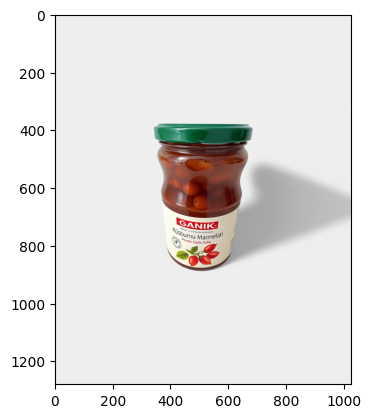

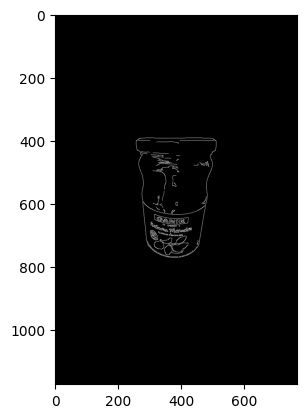

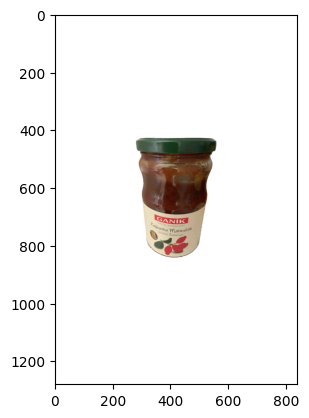

In [143]:
for node_id in images:
    for image_data in images[node_id]:
        from PIL import Image
        import io
        image = Image.open(io.BytesIO(image_data))
        plt.imshow(image)
        plt.show()

In [32]:
import websocket
import uuid
import json
import urllib.request
import urllib.parse
from PIL import Image
from io import BytesIO

def generate_image(prompt_text, server_address="127.0.0.1:8188"):
    client_id = str(uuid.uuid4())

    def queue_prompt(prompt):
        p = {"prompt": prompt, "client_id": client_id}
        data = json.dumps(p).encode('utf-8')
        req = urllib.request.Request(f"http://{server_address}/prompt", data=data)
        return json.loads(urllib.request.urlopen(req).read())

    def get_image(filename, subfolder, folder_type):
        data = {"filename": filename, "subfolder": subfolder, "type": folder_type}
        url_values = urllib.parse.urlencode(data)
        with urllib.request.urlopen(f"http://{server_address}/view?{url_values}") as response:
            return response.read()

    def get_history(prompt_id):
        with urllib.request.urlopen(f"http://{server_address}/history/{prompt_id}") as response:
            return json.loads(response.read())

    def get_images(ws, prompt):
        prompt_id = queue_prompt(prompt)['prompt_id']
        output_images = {}
        while True:
            out = ws.recv()
            if isinstance(out, str):
                message = json.loads(out)
                if message['type'] == 'executing':
                    data = message['data']
                    if data['node'] is None and data['prompt_id'] == prompt_id:
                        break  # Execution is done
            else:
                continue  # previews are binary data

        history = get_history(prompt_id)[prompt_id]
        for node_id in history['outputs']:
            node_output = history['outputs'][node_id]
            images_output = []
            if 'images' in node_output:
                for image in node_output['images']:
                    image_data = get_image(image['filename'], image['subfolder'], image['type'])
                    images_output.append(Image.open(BytesIO(image_data)))
            output_images[node_id] = images_output
        return output_images

    ws = websocket.WebSocket()
    ws.connect(f"ws://{server_address}/ws?clientId={client_id}")
    images = get_images(ws, prompt_text)
    ws.close()

    return images

In [1]:
import websocket
import uuid
import json
import urllib.request
import urllib.parse
from PIL import Image
from io import BytesIO

In [33]:
generate_image(prompt_text, server_address="127.0.0.1:8188")

NameError: name 'prompt_text' is not defined

In [153]:
k={'73': [],
 '115': [""],
 '110': ["<PIL.PngImagePlugin.PngImageFile image mode=RGB size=768x1173>"],
 '69': ["<PIL.PngImagePlugin.PngImageFile image mode=RGB size=838x1280>"]}

In [159]:
list(k.keys()9

SyntaxError: '(' was never closed (2149614364.py, line 1)

In [160]:
k[list(k.keys())[1]]

['']

In [4]:
with open("../src/workflow.json", "r") as f:
    prompt = json.load(f)

In [150]:
prompt_text

{'8': {'inputs': {'samples': ['121', 0], 'vae': ['10', 0]},
  'class_type': 'VAEDecode',
  '_meta': {'title': 'VAE Decode'}},
 '10': {'inputs': {'vae_name': 'ae.safetensors'},
  'class_type': 'VAELoader',
  '_meta': {'title': 'Load VAE'}},
 '16': {'inputs': {'sampler_name': 'euler'},
  'class_type': 'KSamplerSelect',
  '_meta': {'title': 'KSamplerSelect'}},
 '17': {'inputs': {'scheduler': 'beta',
   'steps': 8,
   'denoise': 1,
   'model': ['62', 0]},
  'class_type': 'BasicScheduler',
  '_meta': {'title': 'BasicScheduler'}},
 '22': {'inputs': {'model': ['118', 0], 'conditioning': ['72', 0]},
  'class_type': 'BasicGuider',
  '_meta': {'title': 'BasicGuider'}},
 '25': {'inputs': {'noise_seed': 42},
  'class_type': 'RandomNoise',
  '_meta': {'title': 'RandomNoise'}},
 '31': {'inputs': {'text': ['89', 0], 'clip': ['124', 0]},
  'class_type': 'CLIPTextEncode',
  '_meta': {'title': 'CLIP Text Encode (Prompt)'}},
 '62': {'inputs': {'max_shift': 2.06,
   'base_shift': 0.5,
   'width': 1024,
  

In [57]:
image=Image.open("../Adsız.png")

In [5]:
prompt['63']['inputs']['image'] = "Adsız.png"

In [6]:
prompt

{'8': {'inputs': {'samples': ['121', 0], 'vae': ['10', 0]},
  'class_type': 'VAEDecode',
  '_meta': {'title': 'VAE Decode'}},
 '10': {'inputs': {'vae_name': 'ae.safetensors'},
  'class_type': 'VAELoader',
  '_meta': {'title': 'Load VAE'}},
 '16': {'inputs': {'sampler_name': 'euler'},
  'class_type': 'KSamplerSelect',
  '_meta': {'title': 'KSamplerSelect'}},
 '17': {'inputs': {'scheduler': 'beta',
   'steps': 8,
   'denoise': 1,
   'model': ['62', 0]},
  'class_type': 'BasicScheduler',
  '_meta': {'title': 'BasicScheduler'}},
 '22': {'inputs': {'model': ['118', 0], 'conditioning': ['72', 0]},
  'class_type': 'BasicGuider',
  '_meta': {'title': 'BasicGuider'}},
 '25': {'inputs': {'noise_seed': 42},
  'class_type': 'RandomNoise',
  '_meta': {'title': 'RandomNoise'}},
 '31': {'inputs': {'text': ['89', 0], 'clip': ['124', 0]},
  'class_type': 'CLIPTextEncode',
  '_meta': {'title': 'CLIP Text Encode (Prompt)'}},
 '62': {'inputs': {'max_shift': 2.06,
   'base_shift': 0.5,
   'width': 1024,
  

In [15]:


def generate_image(prompt, image, server_address="127.0.0.1:8188"):
    client_id = str(uuid.uuid4())
    
    with open("../src/workflow.json", "r") as f:
        prompt_text = json.load(f)
    
    prompt_text['63']['inputs']['image'] = "../Adsız.png"
    prompt_text['89']['inputs']['text'] = prompt
    
    
    def queue_prompt(prompt):
        p = {"prompt": prompt, "client_id": client_id}
        data = json.dumps(p).encode('utf-8')
        req = urllib.request.Request(f"http://{server_address}/prompt", data=data)
        return json.loads(urllib.request.urlopen(req).read())

    def get_image(filename, subfolder, folder_type):
        data = {"filename": filename, "subfolder": subfolder, "type": folder_type}
        url_values = urllib.parse.urlencode(data)
        with urllib.request.urlopen(f"http://{server_address}/view?{url_values}") as response:
            return response.read()

    def get_history(prompt_id):
        with urllib.request.urlopen(f"http://{server_address}/history/{prompt_id}") as response:
            return json.loads(response.read())

    def get_images(ws, prompt):
        prompt_id = queue_prompt(prompt)['prompt_id']
        output_images = {}
        while True:
            out = ws.recv()
            if isinstance(out, str):
                message = json.loads(out)
                if message['type'] == 'executing':
                    data = message['data']
                    if data['node'] is None and data['prompt_id'] == prompt_id:
                        break  # Execution is done
            else:
                continue  # previews are binary data
        history = get_history(prompt_id)[prompt_id]
        for node_id in history['outputs']:
            node_output = history['outputs'][node_id]
            images_output = []
            if 'images' in node_output:
                for image in node_output['images']:
                    image_data = get_image(image['filename'], image['subfolder'], image['type'])
                    images_output.append(Image.open(BytesIO(image_data)))
            output_images[node_id] = images_output
        return output_images

    ws = websocket.WebSocket()
    ws.connect(f"ws://{server_address}/ws?clientId={client_id}")
    images = get_images(ws, prompt_text)
    ws.close()
    print(images)
    return images[list(images.keys())[1]][0]  # T

In [16]:
prompt="kahve"

In [17]:
img=generate_image(prompt,"Adsız.png",server_address="127.0.0.1:8188")

{'73': [], '69': [<PIL.PngImagePlugin.PngImageFile image mode=RGB size=996x1280 at 0x7F1889407460>], '115': [<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1024x1280 at 0x7F1889405330>], '110': [<PIL.PngImagePlugin.PngImageFile image mode=RGB size=768x987 at 0x7F1889405390>]}


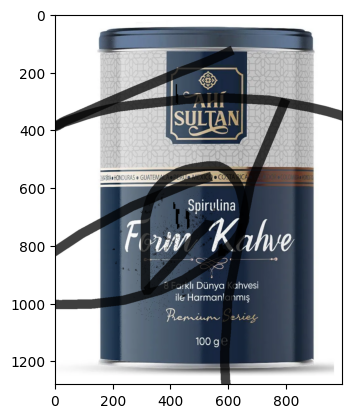

In [20]:
plt.imshow(img)

In [56]:
import base64

def generate_image(prompt, image, server_address="127.0.0.1:8188"):
    client_id = str(uuid.uuid4())
    
    with open("../src/workflow.json", "r") as f:
        prompt_text = json.load(f)
    
    image = Image.open(image)
    buffered = BytesIO()
    image.save(buffered, format="PNG")

    file_path = f"/home/jupyter/temp/{client_id}.png"
    image.save(file_path, format="PNG")

    # Update the prompt_text dictionary
    prompt_text['89']['inputs']['text'] = prompt
    prompt_text['63']['inputs']['image'] = file_path
    def queue_prompt(prompt):
        p = {"prompt": prompt, "client_id": client_id}
        data = json.dumps(p).encode('utf-8')
        req = urllib.request.Request(f"http://{server_address}/prompt", data=data)
        return json.loads(urllib.request.urlopen(req).read())

    def get_image(filename, subfolder, folder_type):
        data = {"filename": filename, "subfolder": subfolder, "type": folder_type}
        url_values = urllib.parse.urlencode(data)
        with urllib.request.urlopen(f"http://{server_address}/view?{url_values}") as response:
            return response.read()

    def get_history(prompt_id):
        with urllib.request.urlopen(f"http://{server_address}/history/{prompt_id}") as response:
            return json.loads(response.read())

    def get_images(ws, prompt):
        prompt_id = queue_prompt(prompt)['prompt_id']
        output_images = {}
        while True:
            out = ws.recv()
            if isinstance(out, str):
                message = json.loads(out)
                if message['type'] == 'executing':
                    data = message['data']
                    if data['node'] is None and data['prompt_id'] == prompt_id:
                        break  # Execution is done
            else:
                continue  # previews are binary data
        history = get_history(prompt_id)[prompt_id]
        for node_id in history['outputs']:
            node_output = history['outputs'][node_id]
            images_output = []
            if 'images' in node_output:
                for image in node_output['images']:
                    image_data = get_image(image['filename'], image['subfolder'], image['type'])
                    images_output.append(Image.open(BytesIO(image_data)))
            output_images[node_id] = images_output
        return output_images

    ws = websocket.WebSocket()
    ws.connect(f"ws://{server_address}/ws?clientId={client_id}")
    images = get_images(ws, prompt_text)
    ws.close()
    #return images[list(images.keys())[1]][0]
    return images

In [57]:
img=generate_image("pillow","../temp/9eb83035-52ad-4912-831a-931b818d6fac.png",server_address="127.0.0.1:8188")

In [59]:
img

{'115': [<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1024x1280>],
 '110': [<PIL.PngImagePlugin.PngImageFile image mode=RGB size=768x1154>],
 '69': [<PIL.PngImagePlugin.PngImageFile image mode=RGB size=852x1280>],
 '73': []}

In [50]:
image = Image.open(io.BytesIO(img['69']PngImageFile image mode=RGB size=598x1280>],
 '110': [<PIL.PngImagePlugin.PngImageFile[0]))
plt.imshow(image)
plt.show()

SyntaxError: invalid decimal literal (1052108242.py, line 1)

In [60]:
1024 in img['115'][0].size

True

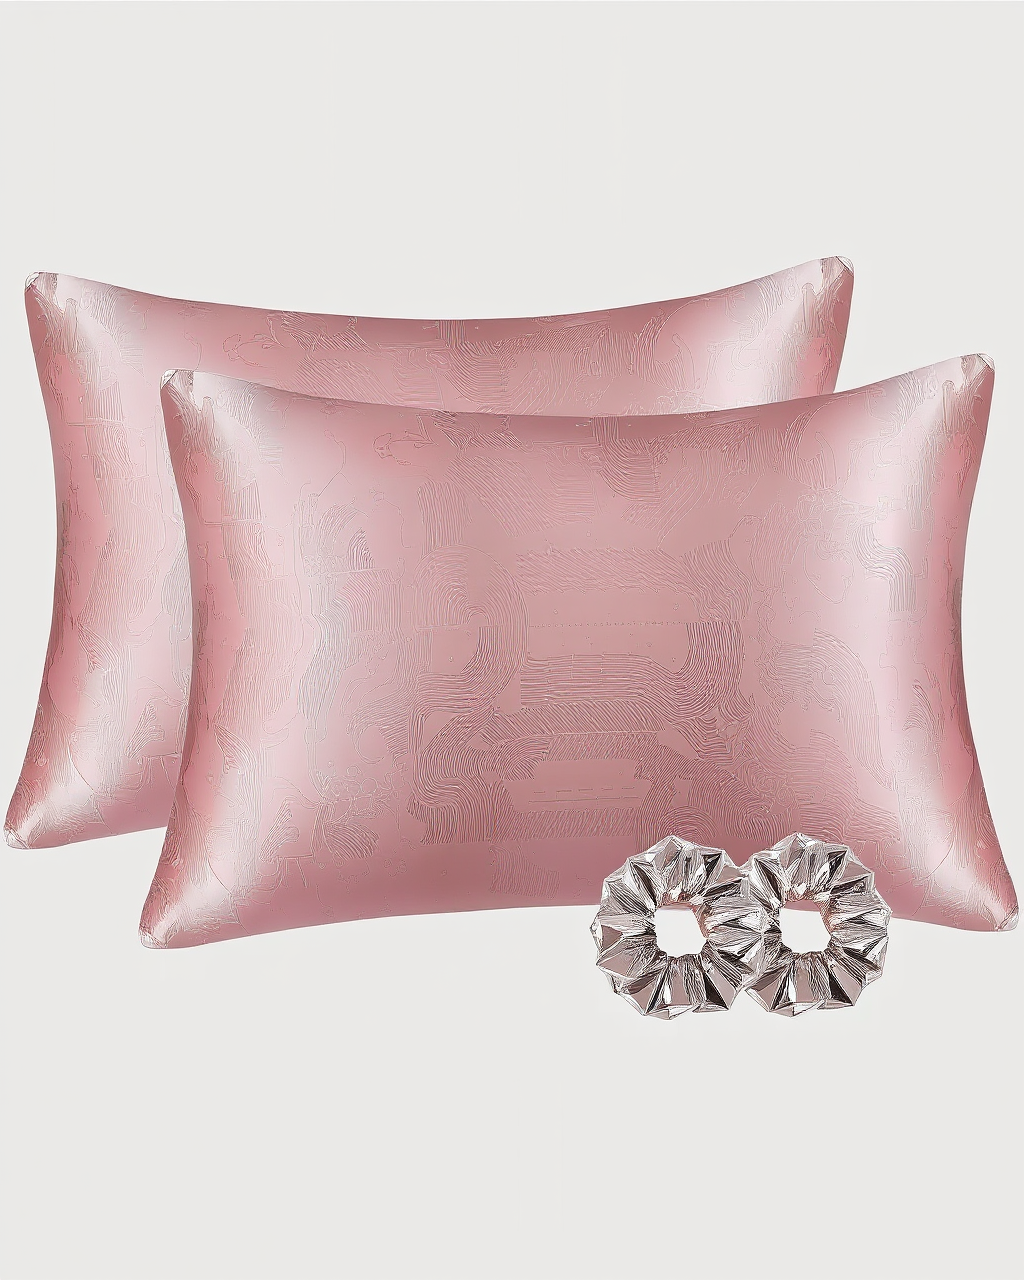

In [61]:
img['115'][0]

In [78]:
import subprocess
import os
import signal

class GgufManager:
    def __init__(self):
        self.command = "./llama.cpp/llama-server -m ./gguf/gemma-2-9b-it-Q4_K_M.gguf -t 5 --port 8001 -ngl 43 -c 8192"
        self.process = None

    def run(self):
        
        self.process = subprocess.Popen(self.command, shell=True)
        print(f"Process started with PID: {self.process.pid+1}")
        return self.process.pid+1

    def kill(self):
        """PID'yi öldür."""
        if self.process is not None:
            print(f"Killing process with PID: {self.process.pid+1}")
            os.kill(self.process.pid+1, signal.SIGTERM)
            self.process = None
        else:
            print("No process is running.")

In [79]:
commandHandler=CommandHandler("../llama.cpp/llama-server -m ../gguf/gemma-2-9b-it-Q4_K_M.gguf -t 5 --port 8001 -ngl 43 -c 8192")

In [80]:
commandHandler.run()

Process started with PID: 1465202


1465203

build: 3841 (faac0bae) with cc (Debian 10.2.1-6) 10.2.1 20210110 for x86_64-linux-gnu
system info: n_threads = 5, n_threads_batch = 5, total_threads = 12

system_info: n_threads = 5 (n_threads_batch = 5) / 12 | AVX = 1 | AVX_VNNI = 0 | AVX2 = 1 | AVX512 = 1 | AVX512_VBMI = 0 | AVX512_VNNI = 1 | AVX512_BF16 = 0 | FMA = 1 | NEON = 0 | SVE = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | RISCV_VECT = 0 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | MATMUL_INT8 = 0 | LLAMAFILE = 1 | 

main: HTTP server is listening, hostname: 127.0.0.1, port: 8001, http threads: 11
main: loading model
llama_model_loader: loaded meta data with 33 key-value pairs and 464 tensors from ../gguf/gemma-2-9b-it-Q4_K_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = gemma2
llama_model_loader: - kv   1:                               g

In [75]:
!ps -a

    PID TTY          TIME CMD
1412724 pts/7    00:00:00 vim
1414772 pts/8    00:00:01 npm exec localt
1414834 pts/8    00:00:00 sh
1414835 pts/8    00:00:00 node
1419915 pts/4    00:01:36 ngrok
1423171 pts/8    00:05:09 nvitop
1456645 pts/0    00:04:51 pt_main_thread
1459315 pts/2    00:01:58 pt_main_thread
1461314 pts/1    00:00:47 streamlit


In [81]:
commandHandler.kill()

Killing process with PID: 1465202


Terminated


In [ ]:
commandHandler

In [77]:
!kill 1465062

In [82]:
image_id="f7ec3207b76b3eb3de76c79dff26fd8aa60d4969f1d7aa324555aacc26252681"

In [83]:
if f"{image_id}.png" in os.listdir(f"/home/jupyter/temp/out/"):
    print(image_id)

f7ec3207b76b3eb3de76c79dff26fd8aa60d4969f1d7aa324555aacc26252681


In [108]:
def hash_string(input_string):
    hashed = hashlib.md5(input_string.encode('utf-8')).hexdigest()
    return hashed

def hash_image(image_path):
    with open(image_path, 'rb') as f:
        image_data = f.read()
        return hashlib.md5(image_data).hexdigest()

In [113]:
image = Image.open("/home/jupyter/temp/in/058707447631735410f9999458e5589f9c3772751d6fedcb0fff2e77de3be77b.png")
image_id=hash_image("/home/jupyter/temp/in/058707447631735410f9999458e5589f9c3772751d6fedcb0fff2e77de3be77b.png")

In [114]:
image_id

'25999062f9f3490f1cbeca008ca168d7'

In [112]:
image_id

'25999062f9f3490f1cbeca008ca168d7'

In [125]:
import numpy as np
file_bytes = np.frombuffer(open("/home/jupyter/temp/in/058707447631735410f9999458e5589f9c3772751d6fedcb0fff2e77de3be77b.png", "rb").read(), np.uint8)
image = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
def hash_string(s):
    return hashlib.sha256(s.encode()).hexdigest()

image_id = hash_string(str(image))

In [126]:
image_id

'7479d935f3af7920192079ce2a0bc8a9457432c7d3c0de0fff2fd62f2090e5aa'

In [124]:
image_id

'7479d935f3af7920192079ce2a0bc8a9457432c7d3c0de0fff2fd62f2090e5aa'